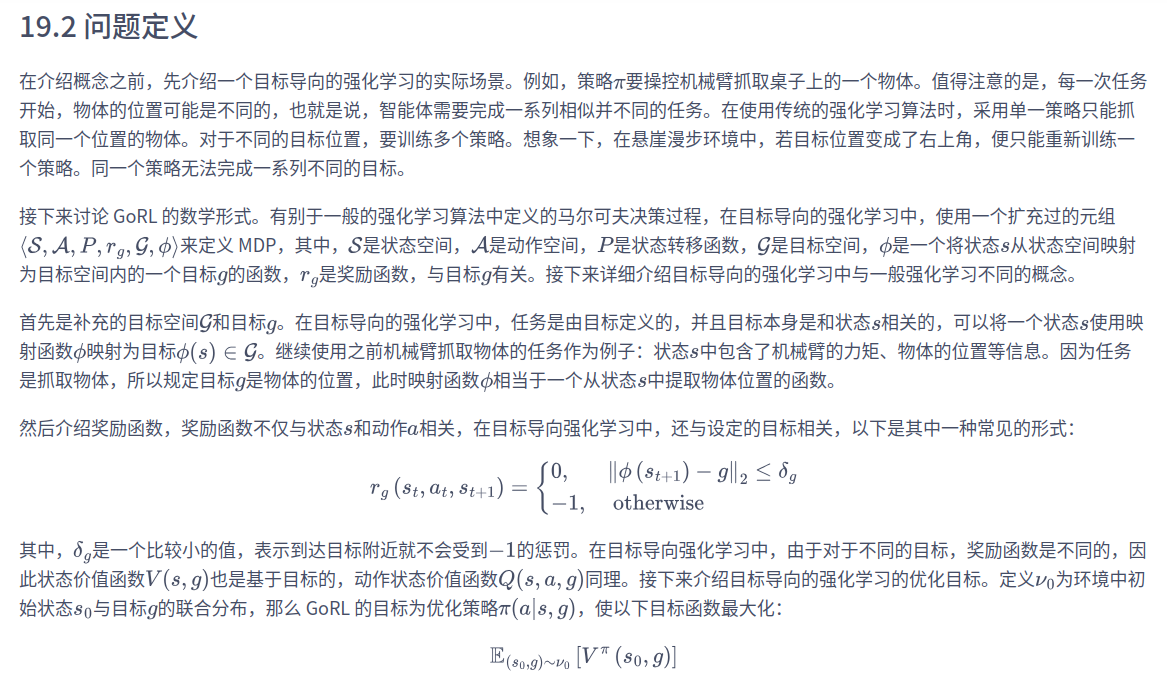  
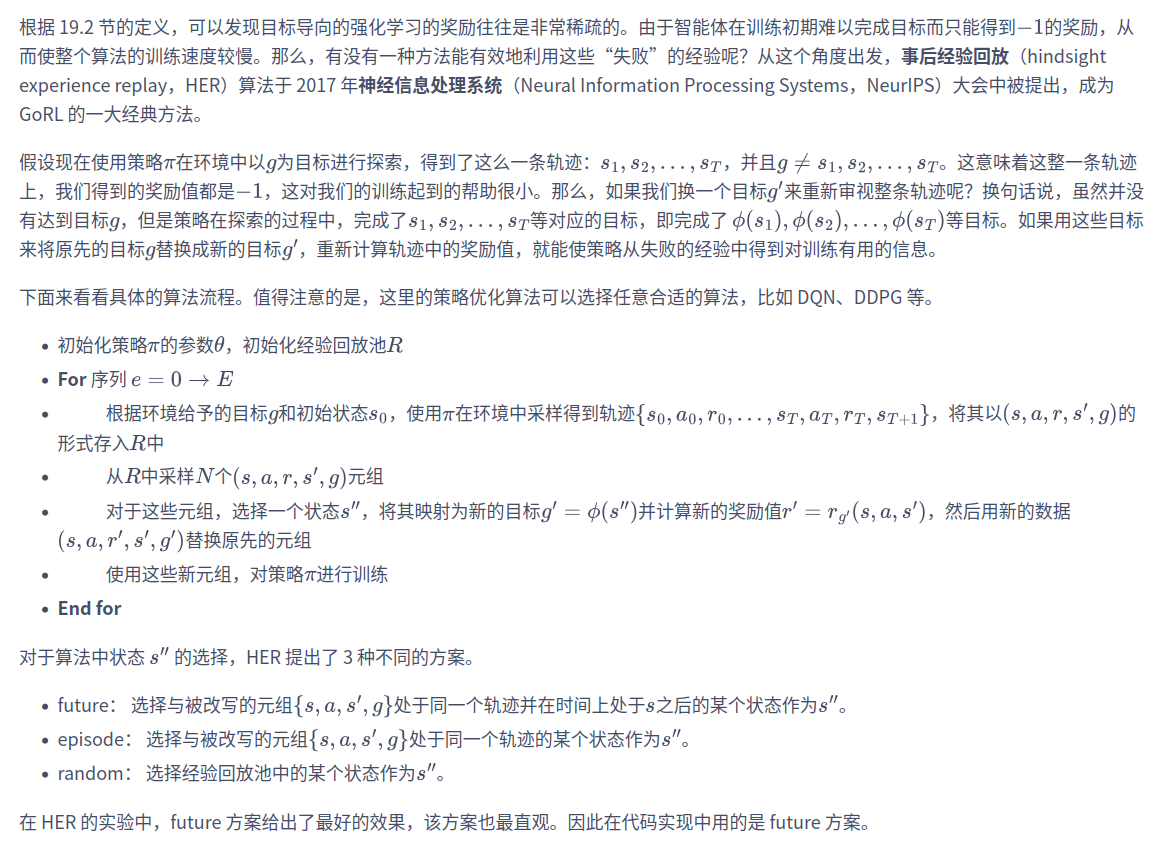  
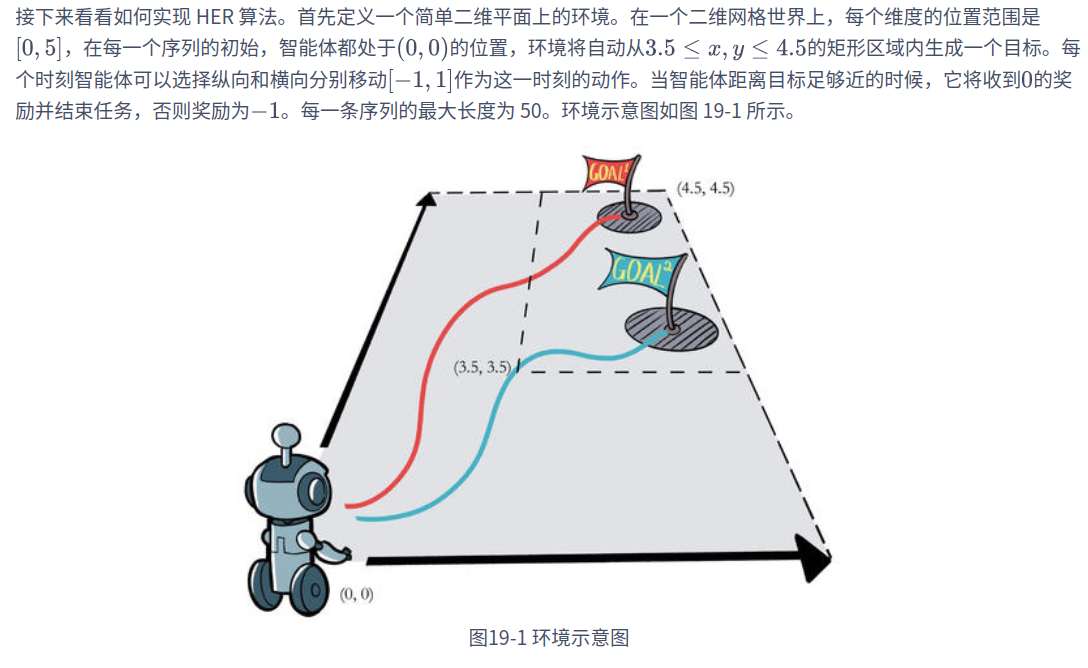   

In [26]:
import torch
import torch.nn.functional as F
import numpy as np
import random
from tqdm import tqdm
import collections
import matplotlib.pyplot as plt


class WorldEnv:
    def __init__(self):
        self.distance_threshold = 0.15
        self.action_bound = 1

    def reset(self,goal=None):  # 重置环境
        if(goal):
            self.goal=np.array(goal)
        else:
            # 生成一个目标状态, 坐标范围是[3.5～4.5, 3.5～4.5]
            self.goal = np.array(
                [4 + random.uniform(-0.5, 0.5), 4 + random.uniform(-0.5, 0.5)])
        self.state = np.array([0, 0])  # 初始状态
        self.count = 0
        return np.hstack((self.state, self.goal))
    # 状态的最后两个维度是目标位置


    def step(self, action):
        action = np.clip(action, -self.action_bound, self.action_bound)
        x = max(0, min(5, self.state[0] + action[0]))
        y = max(0, min(5, self.state[1] + action[1]))
        # 限制在[0,5]之间
        self.state = np.array([x, y])
        self.count += 1

        dis = np.sqrt(np.sum(np.square(self.state - self.goal)))
        reward = -1.0 if dis > self.distance_threshold else 0
        if dis <= self.distance_threshold or self.count == 50:
            done = True
        else:
            done = False

        return np.hstack((self.state, self.goal)), reward, done

In [27]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return torch.tanh(self.fc3(x)) * self.action_bound
        # 输出连续的动作值，范围是[-action_bound,action_bound]


class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)  # 拼接状态和动作
        x = F.relu(self.fc2(F.relu(self.fc1(cat))))
        return self.fc3(x)
        # 输入s,a输出q

环境中动作有 2 维

In [28]:
class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, sigma, tau, gamma, device):
        self.action_dim = action_dim
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim,action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)

        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim,action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim,action_dim).to(device)

        # 初始化目标价值网络并使其参数和价值网络一样
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化目标策略网络并使其参数和策略网络一样
        self.target_actor.load_state_dict(self.actor.state_dict())

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值直接设为0
        self.tau = tau  # 目标网络软更新参数
        self.action_bound = action_bound
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state).detach().cpu().numpy()[0]
        # 给动作添加噪声，增加探索
        action = action + self.sigma * np.random.randn(self.action_dim)
        return action

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +param.data * self.tau)

    def update(self, transition_dict):
        # (batch_size,state_dim)
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        # (batch_size,action_dim)
        actions = torch.tensor(transition_dict['actions'],dtype=torch.float).to(self.device)
        # (batch_size,1)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(next_states,self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        # MSE损失函数
        critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # 策略网络就是为了使Q值最大化
        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor, self.target_actor)  # 软更新策略网络
        self.soft_update(self.critic, self.target_critic)  # 软更新价值网络

接下来定义一个特殊的经验回放池，此时回放池内不再存储每一步的数据，而是存储一整条轨迹。  
这是 HER 算法中的核心部分，之后可以用 HER 算法从该经验回放池中构建新的数据来帮助策略训练。

In [29]:
class Trajectory:
    ''' 用来记录一条完整轨迹 '''
    def __init__(self, init_state):
        self.states = [init_state]
        self.actions = []
        self.rewards = []
        self.dones = []
        self.length = 0

    def store_step(self, action, state, reward, done):
        self.actions.append(action)
        self.states.append(state)
        self.rewards.append(reward)
        self.dones.append(done)
        self.length += 1


class ReplayBuffer_Trajectory:
    ''' 存储轨迹的经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add_trajectory(self, trajectory):
        self.buffer.append(trajectory)

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size, use_her, dis_threshold=0.15, her_ratio=0.8):
        batch = dict(states=[],
                     actions=[],
                     next_states=[],
                     rewards=[],
                     dones=[])
        for _ in range(batch_size):
            # random.sample(self.buffer, n)随机选n个buffer里的元素,返回一个列表[trj1,...trjn]
            traj = random.sample(self.buffer, 1)[0]
            step_state = np.random.randint(traj.length)
            state = traj.states[step_state]
            next_state = traj.states[step_state + 1]
            action = traj.actions[step_state]
            reward = traj.rewards[step_state]
            done = traj.dones[step_state]

            if use_her and np.random.uniform() <= her_ratio:
                # 使用HER算法的future方案设置目标
                # 对随机新目标对应的新状态、奖励、next_state、done进行重写
                # 左闭右开[step_state + 1, traj.length + 1)
                step_goal = np.random.randint(step_state + 1, traj.length + 1)
                # state:(x,y,xg,yg)
                goal = traj.states[step_goal][:2]  
                dis = np.sqrt(np.sum(np.square(next_state[:2] - goal)))
                reward = -1.0 if dis > dis_threshold else 0
                done = False if dis > dis_threshold else True
                state = np.hstack((state[:2], goal))
                next_state = np.hstack((next_state[:2], goal))

            batch['states'].append(state)
            batch['next_states'].append(next_state)
            batch['actions'].append(action)
            batch['rewards'].append(reward)
            batch['dones'].append(done)

        batch['states'] = np.array(batch['states'])
        batch['next_states'] = np.array(batch['next_states'])
        batch['actions'] = np.array(batch['actions'])
        return batch

In [30]:
actor_lr = 1e-3
critic_lr = 1e-3
hidden_dim = 128
state_dim = 4
action_dim = 2
action_bound = 1
sigma = 0.1
tau = 0.005
gamma = 0.98
num_episodes = 2000
n_train = 20
batch_size = 256
minimal_episodes = 200
buffer_size = 10000
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
env = WorldEnv()
replay_buffer = ReplayBuffer_Trajectory(buffer_size)
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, actor_lr,
             critic_lr, sigma, tau, gamma, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            traj = Trajectory(state)
            done = False
            while not done:
                action = agent.take_action(state)
                state, reward, done = env.step(action)
                episode_return += reward
                traj.store_step(action, state, reward, done)
            replay_buffer.add_trajectory(traj)
            return_list.append(episode_return)
            if replay_buffer.size() >= minimal_episodes:
                for _ in range(n_train):
                    transition_dict = replay_buffer.sample(batch_size, True)
                    agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)



Iteration 9: 100%|██████████| 200/200 [00:16<00:00, 12.04it/s, episode=2000, return=-3.900]


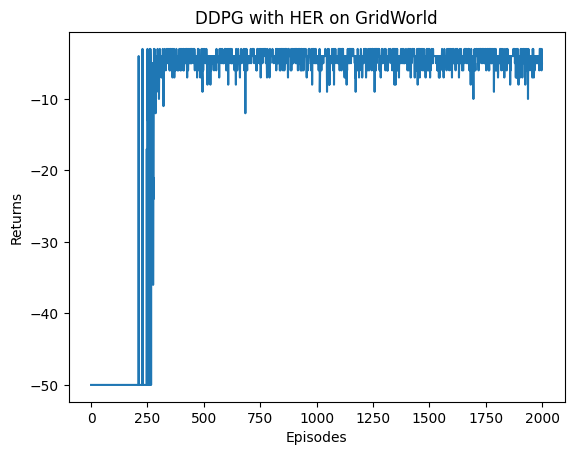

In [31]:

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG with HER on {}'.format('GridWorld'))
plt.show()

In [32]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
env = WorldEnv()
replay_buffer = ReplayBuffer_Trajectory(buffer_size)
agent1 = DDPG(state_dim, hidden_dim, action_dim, action_bound, actor_lr,
             critic_lr, sigma, tau, gamma, device)

return_list1 = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            traj = Trajectory(state)
            done = False
            while not done:
                action = agent1.take_action(state)
                state, reward, done = env.step(action)
                episode_return += reward
                traj.store_step(action, state, reward, done)
            replay_buffer.add_trajectory(traj)
            return_list1.append(episode_return)
            if replay_buffer.size() >= minimal_episodes:
                for _ in range(n_train):
                    # 和使用HER训练的唯一区别
                    transition_dict = replay_buffer.sample(batch_size, False)
                    agent1.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list1[-10:])
                })
            pbar.update(1)


Iteration 9: 100%|██████████| 200/200 [00:12<00:00, 16.52it/s, episode=2000, return=-50.000]


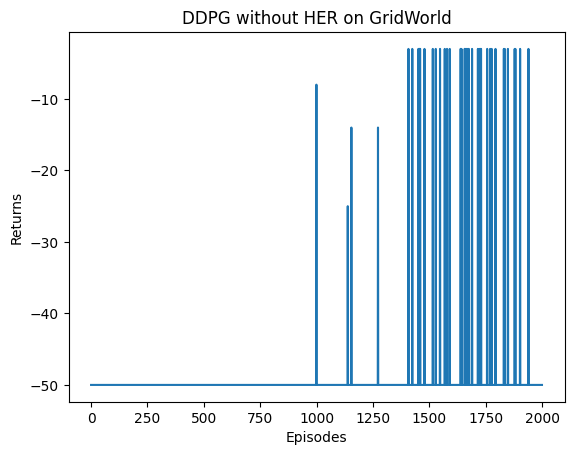

In [33]:
episodes_list1 = list(range(len(return_list1)))
plt.plot(episodes_list1, return_list1)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG without HER on {}'.format('GridWorld'))
plt.show()


In [34]:
from typing import List
def evaluate_goal_generalization(agent, env, test_goals: List, num_episodes: int = 10, max_steps: int = 50):
    """
    评估训练好的GORL智能体在多个测试目标上的表现
    """
    success_rates = {}
    episode_returns = {}
    for goal in test_goals:
        print(f"评估目标: {goal}")
        successes = 0
        total_returns = []
        for ep in range(num_episodes):
            # 重置环境，并设置特定的测试目标
            state = env.reset(goal)# 假设环境有设置目标的方法
            state = np.hstack((state[:2], goal))  # 构建目标条件状态
            episode_reward = 0
            success = False
            for step in range(max_steps):
                action = agent.take_action(state)  # 评估时通常不加探索噪声
                next_state, reward, done = env.step(action)
                next_state = np.hstack((next_state[:2], goal))
                episode_reward += reward
                state = next_state
                if done:
                    if reward == 0:  # 假设到达目标时奖励为0
                        successes += 1
                        success = True
                    break
            total_returns.append(episode_reward)
        success_rate = successes / num_episodes
        avg_return = np.mean(total_returns)
        success_rates[tuple(goal)] = success_rate
        episode_returns[tuple(goal)] = avg_return
        print(f"目标 {goal}: 成功率 = {success_rate:.2f}, 平均回报 = {avg_return:.2f}")
    return success_rates, episode_returns

In [35]:
trained_agent = agent
# 定义一组测试目标（可包含训练中未见过的目标）
test_goals = [
    [4.0, 4.0],   # 训练见过的目标
    [1.0, 1.0],   # 训练区域内的新目标
    [4.5, 0.5],   # 训练区域边角的新目标
    [2.5, 3.5]    # 训练区域内的另一个新目标
]

# 进行评估
success_rates, returns = evaluate_goal_generalization(trained_agent, env, test_goals)

# 计算整体平均成功率，作为泛化能力的指标
overall_success_rate = np.mean(list(success_rates.values()))
print(f"\n整体平均成功率: {overall_success_rate:.2f}")

评估目标: [4.0, 4.0]
目标 [4.0, 4.0]: 成功率 = 1.00, 平均回报 = -4.30
评估目标: [1.0, 1.0]
目标 [1.0, 1.0]: 成功率 = 1.00, 平均回报 = -0.40
评估目标: [4.5, 0.5]
目标 [4.5, 0.5]: 成功率 = 1.00, 平均回报 = -7.20
评估目标: [2.5, 3.5]
目标 [2.5, 3.5]: 成功率 = 1.00, 平均回报 = -3.40

整体平均成功率: 1.00


通过实验对比，可以观察到使用 HER 算法后，效果有显著提升。  
这里 HER 算法的主要好处是通过重新对历史轨迹设置其目标（使用 future 方案）而使得奖励信号更加稠密，进而从原本失败的数据中学习到使“新任务”成功的经验，提升训练的稳定性和样本效率。

本章介绍了目标导向的强化学习（GoRL）的基本定义，以及一个解决 GoRL 的有效的经典算法 HER。  
通过代码实践，HER 算法的效果得到了很好的呈现。我们从 HER 的代码实践中还可以领会一种思维方式，即可以通过整条轨迹的信息来改善每个转移片段带给智能体策略的学习价值。  
例如，在 HER 算法的 future 方案中，采样当前轨迹后续的状态作为目标，然后根据下一步状态是否离目标足够近来修改当前步的奖励信号。  
此外，HER 算法只是一个经验回放的修改方式，并没有对策略网络和价值网络的架构做出任何修改。  
而在后续的部分 GoRL 研究中，策略函数和动作价值函数会被显式建模成$\pi(a|s,g)$和$Q(s,a,g)$，即构建较为复杂的策略架构，  
使其直接知晓当前状态和目标，并使用更大的网络容量去完成目标。有兴趣的读者可以自行查阅相关的文献。